# 第2章　最小二乗法：機械学習理論の第一歩

## 2.1 多項式近似と最小二乗法による推定

必要なモジュールをインポートします。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

from numpy.random import normal

import matplotlib
matplotlib.rcParams['font.size'] = 12

正弦関数に正規分布のノイズを載せたデータセットを生成する関数を定義します。

これは、$0\le x\le 1$ の区間を等分した `num` 個の点 $\{x_n\}_{n=1}^N$ に対して、対応する $\{t_n\}_{n=1}^N$ の値を生成します。

In [2]:
def create_dataset(num):
  xs = np.linspace(0, 1, num)
  ts = np.sin(2*np.pi*xs) + normal(loc=0, scale=0.3, size=num)
  return xs, ts

例として、10 個のデータをトレーニングセットとして生成します。

In [3]:
N = 10 # データ数
xs, ts = create_dataset(N)

DataFrame({'x': xs, 't': ts})

,x,t
0,0.000000,-0.277920
1,0.111111,0.590905
2,0.222222,1.014941
3,0.333333,1.146664
4,0.444444,0.669489
5,0.555556,-0.387329
6,0.666667,-1.196214
7,0.777778,-0.505059
8,0.888889,-0.792784
9,1.000000,-0.154997


グラフ上にプロットすると次のようになります。

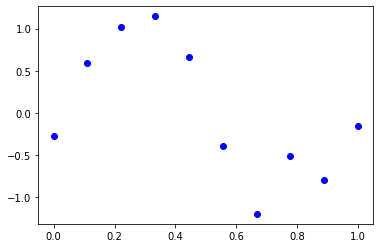

In [4]:
plt.scatter(xs, ts, marker='o', color='blue')

このデータに対して、最小二乗法でフィッティングした m 次多項式を決定する関数を定義します。

引数 `xs`、`ts`にトレーニングセットのデータ、`m` に多項式の次数を代入すると、多項式に対応する関数 $f(x)$ のオブジェクト、および、係数 $\{w_0,\cdots,w_m\}$ の値を格納した array オブジェクトが返ります。

In [5]:
def resolve(xs, ts, m):
  phi = np.array([[x**k for k in range(m+1)] for x in xs])
  tmp = np.linalg.inv(np.dot(phi.T, phi))
  ws = np.dot(np.dot(tmp, phi.T), ts)

  def f(x):
    y = 0
    for i, w in enumerate(ws):
      y += w * x**i 
    return y
  
  return f, ws

得られた関数 $f(x)$ に対して、トレーニングセットに対する平方根平均二乗誤差（RMS）を求める関数を定義します。

In [6]:
def rms_error(xs, ts, f):
  err = 0.5 * np.sum((ts - f(xs))**2)
  return np.sqrt(2 * err / len(xs))

これらを用いて、結果をグラフに可視化する関数を定義します。

In [7]:
def show_result(subplot, xs, ts, m):
  f, _ = resolve(xs, ts, m)
  subplot.set_xlim(-0.05, 1.05)
  subplot.set_ylim(-1.5, 1.5)
  subplot.set_title('M={}'.format(m), fontsize=14)

  # トレーニングセットを表示
  subplot.scatter(xs, ts, marker='o', color='blue', label=None)

  # 真の曲線を表示
  linex = np.linspace(0, 1, 100)
  liney = np.sin(2*np.pi*linex)
  subplot.plot(linex, liney, color='green', linestyle='--')

  # 多項式近似の曲線を表示
  linex = np.linspace(0, 1, 100)
  liney = f(linex)
  label = 'E(RMS)={:.2f}'.format(rms_error(xs, ts, f))
  subplot.plot(linex, liney, color='red', label=label)
  subplot.legend(loc=1, fontsize=14)

先ほど生成したトレーニングセットを用いて、0, 1, 3, 9次多項式でフィッティングした結果を表示します。

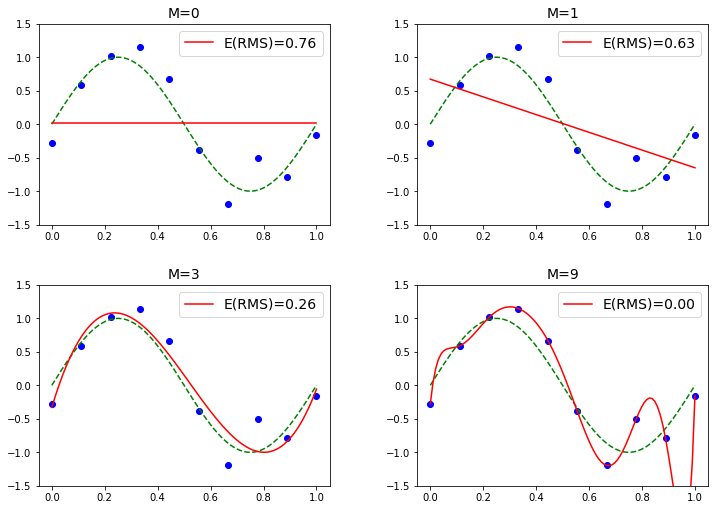

In [8]:
fig = plt.figure(figsize=(12, 8.5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, m in enumerate([0, 1, 3, 9]):
  subplot = fig.add_subplot(2, 2, i+1)
  show_result(subplot, xs, ts, m)

最小二乗法で得られた係数 $\{w_m\}_{m=0}^M$ の具体的な値を表示します。

多項式の次数が上がると、係数の値が極端に大きくなることがわかります。

In [9]:
weights = {}
for m in [0, 1, 3, 9]:
  _, ws = resolve(xs, ts, m)
  weights['M={}'.format(m)] = Series(ws)

DataFrame(weights)

,M=0,M=1,M=3,M=9
0,0.01077,0.672542,-0.329725,-0.277783
1,NaN,-1.323544,13.194966,37.053838
2,NaN,NaN,-36.010861,-658.517909
3,NaN,NaN,23.088599,5945.081051
4,NaN,NaN,NaN,-29312.769051
5,NaN,NaN,NaN,85592.632308
6,NaN,NaN,NaN,-152648.027911
7,NaN,NaN,NaN,162568.851378
8,NaN,NaN,NaN,-94478.503228
9,NaN,NaN,NaN,22954.322070


## 2.2 オーバーフィッティングの検出

多項式の次数を 0〜9 に変化させながら、平方根平均二乗誤差のグラフを描く関数を用意します。

In [10]:
def show_rms_trend(xs, ts, val_xs, val_ts):
  rms_errors = {'Training set': [], 'Test set': []}
  for m in range(0, 10):
    f, _ = resolve(xs, ts, m)
    rms_errors['Training set'].append(rms_error(xs, ts, f))
    rms_errors['Test set'].append(rms_error(val_xs, val_ts, f))
  df = DataFrame(rms_errors)
  df.plot(title='RMS Error', style=['-', '--'], grid=True,
          xticks=range(0, 10), figsize=(8, 5), ylim=(0, 0.9))

トレーニングセットとは独立に生成したテストセットを用意します。

In [11]:
val_xs, val_ts = create_dataset(N)

DataFrame({'val_x': val_xs, 'val_t': val_ts})

,val_x,val_t
0,0.000000,0.273032
1,0.111111,1.103509
2,0.222222,0.668981
3,0.333333,1.238610
4,0.444444,0.256708
5,0.555556,-0.434034
6,0.666667,-0.726764
7,0.777778,-0.944373
8,0.888889,-0.659427
9,1.000000,0.352988


トレーニングセットとテストセットに対する平方根平均二条誤差を計算して、結果をグラフ表示にします。

次数が3を超えるとテストセットに対する誤差が減少しなくなることがわかります。

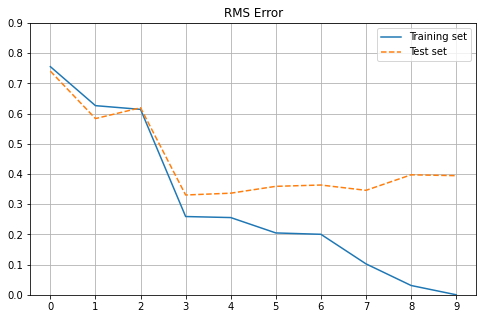

In [12]:
show_rms_trend(xs, ts, val_xs, val_ts)

同じ計算をデータ数を増やして実施してみます。

N = 100 でトレーニングセットとテストセットを用意します。

In [13]:
N = 100 # データ数
xs, ts = create_dataset(N)
val_xs, val_ts = create_dataset(N)

最小二乗法でフィッティングした結果を表示します。

多項式の次数が上がってもオーバーフィッティングが発生しにくくなっていることがわかります。

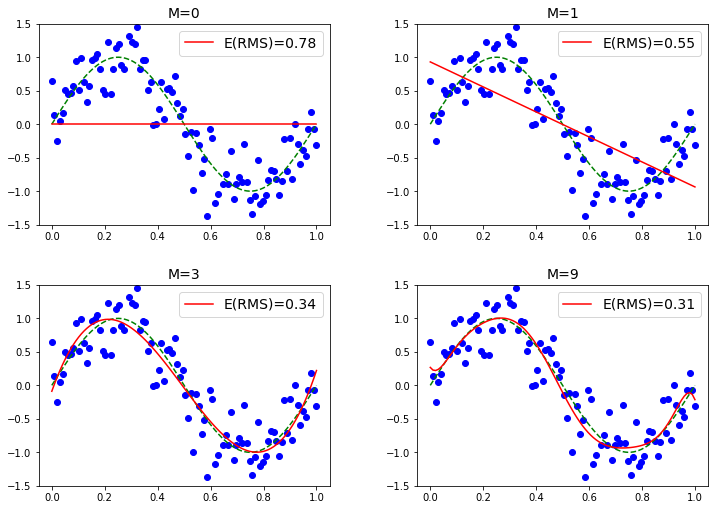

In [14]:
fig = plt.figure(figsize=(12, 8.5))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, m in enumerate([0, 1, 3, 9]):
  subplot = fig.add_subplot(2, 2, i+1)
  show_result(subplot, xs, ts, m)



トレーニングセットとテストセットに対する平方根平均二乗誤差の変化を表示します。

次数が 3 を超えると平方根平均二乗誤差が約 0.3 で一定になります。これは、このデータが本質的に ±0.3 程度の誤差を持っている事を示します。

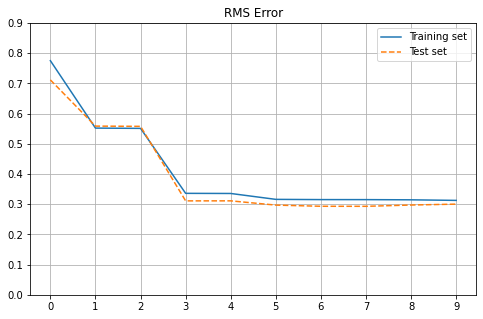

In [15]:
show_rms_trend(xs, ts, val_xs, val_ts)